## Analysis of Healthcare Spending and Alzheimer's Disease

This notebook explores the relationship between healthcare spending and Alzheimer's disease prevalence. It includes data preprocessing, visualization, and key insights.

**Sections:**
1. Data Loading and Preprocessing
2. Exploratory Data Analysis
3. Visualization and Insights


## Import (and install) libraries

In [51]:
# !pip install fuzzywuzzy
# !pip install python-Levenshtein  # Optional, for better performance
# !pip install pycountry_convert

     |████████████████████████████████| 6.3 MB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 207 kB 27.7 MB/s eta 0:00:01


In [389]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

In [391]:
os.getcwd()

'/Users/marinarakic/Kaggle_Projects/Healthcare_spending_Alzheimers'

## Load datasets

Loading the below datasets obtained from open resource databses:

In [393]:
# Replace these paths with the actual paths to your files
alzheimers_data = pd.read_csv('./alzheimers_prevalence/alzheimers_prevalence.csv')
healthcare_data = pd.read_csv('./healthcare_spending/healthcare_spending.csv', skiprows=4)
population_data = pd.read_csv('./healthcare_spending/population_total.csv', skiprows=4)

In [395]:
# Display the first few rows of each dataset
print("Alzheimer’s Data:")
print(alzheimers_data.head())
print("\nHealthcare Spending Data:")
print(healthcare_data.head())
print("\nPopulation Data:")
print(population_data.head())

Alzheimer’s Data:
   measure_id measure_name  location_id    location_name  sex_id sex_name  \
0           5   Prevalence           37  Kyrgyz Republic       3     Both   
1           5   Prevalence           37  Kyrgyz Republic       3     Both   
2           5   Prevalence           37  Kyrgyz Republic       3     Both   
3           5   Prevalence           37  Kyrgyz Republic       3     Both   
4           5   Prevalence           37  Kyrgyz Republic       3     Both   

   age_id  age_name  cause_id                               cause_name  \
0      22  All ages       543  Alzheimer's disease and other dementias   
1      22  All ages       543  Alzheimer's disease and other dementias   
2      22  All ages       543  Alzheimer's disease and other dementias   
3      22  All ages       543  Alzheimer's disease and other dementias   
4      22  All ages       543  Alzheimer's disease and other dementias   

   metric_id metric_name  year           val         upper         lower  

In [397]:
# Check column names and info for both datasets
print("\nAlzheimer’s Data Info:")
print(alzheimers_data.info())
print("\nHealthcare Spending Data Info:")
print(healthcare_data.info())


Alzheimer’s Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12852 entries, 0 to 12851
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   measure_id     12852 non-null  int64  
 1   measure_name   12852 non-null  object 
 2   location_id    12852 non-null  int64  
 3   location_name  12852 non-null  object 
 4   sex_id         12852 non-null  int64  
 5   sex_name       12852 non-null  object 
 6   age_id         12852 non-null  int64  
 7   age_name       12852 non-null  object 
 8   cause_id       12852 non-null  int64  
 9   cause_name     12852 non-null  object 
 10  metric_id      12852 non-null  int64  
 11  metric_name    12852 non-null  object 
 12  year           12852 non-null  int64  
 13  val            12852 non-null  float64
 14  upper          12852 non-null  float64
 15  lower          12852 non-null  float64
dtypes: float64(3), int64(7), object(6)
memory usage: 1.6+ MB
None

Healthc

## Cleaning and organizing datasets

### Changing data format into long and renaming columns

In [399]:
# 1. Rename columns in Alzheimer’s data
alzheimers_data.rename(columns={
    'location_name': 'Country',
    'year': 'Year',
    'val': 'Alzheimers Cases'
}, inplace=True)

# Select only the relevant columns
alzheimers_data = alzheimers_data[['Country', 'Year','metric_name', 'Alzheimers Cases']]


# 2. Rename columns in healthcare spending data
healthcare_data.rename(columns={
    'Country Name': 'Country'
}, inplace=True)

    ## Melt the wide data into a long format
healthcare_data = healthcare_data.melt(
    id_vars=['Country'], 
    var_name='Year', 
    value_name='Healthcare Spending (% of GDP)'
)

    ## Convert 'Year' column to numeric
healthcare_data['Year'] = pd.to_numeric(healthcare_data['Year'], errors='coerce')

    ## Drop rows with NaN years or spending values
healthcare_data.dropna(subset=['Year', 'Healthcare Spending (% of GDP)'], inplace=True)

# 3. Rename columns in  population data
population_data.rename(columns={
    'Country Name': 'Country'
}, inplace=True)

population_data = population_data.melt(
    id_vars=['Country'], 
    var_name='Year', 
    value_name='Population'
)
#  'Year' column to numeric
population_data['Year'] = pd.to_numeric(population_data['Year'], errors='coerce')
# Drop rows with NaN years or values
population_data.dropna(subset=['Year', 'Population'], inplace=True)



### Unifying different country namings in the datasets

First we check how many unique names our first dataset contains. We will try to align the names based on Alzheimer's dataset as they are more concise. 

In [401]:
alzheimers_data['Country'].nunique()

204

In [403]:
old_names = alzheimers_data['Country'].unique()

In [405]:
import numpy as np
from fuzzywuzzy import process

# Get unique values from both DataFrames
alzheimers_countries = alzheimers_data['Country'].unique()
healthcare_countries = healthcare_data['Country'].unique()

# Convert arrays to lists for fuzzy matching
alzheimers_list = list(alzheimers_countries)
healthcare_list = list(healthcare_countries)

# Create a dictionary to hold the country mapping
country_mapping = {}
no_match = []
full_match_count = 0

# Define manual mappings for common variations
manual_mappings = {
    "Lao People's Democratic Republic": "Lao PDR",
    "Federated States of Micronesia": "Micronesia, Fed. Sts.",
    "Democratic People's Republic of Korea": "Korea, Dem. People's Rep.",
    "People's Republic of China": "China",
    "Republic of Korea": "Korea, Rep.",
    "Czech Republic": "Czechia",
    "Argentine Republic": "Argentina",
    "Bolivarian Republic of Venezuela": "Venezuela, RB",
    "United Mexican States": "Mexico",
    "Hellenic Republic": "Greece",
    "French Republic": "France",
    "Swiss Confederation": "Switzerland",
    "Arab Republic of Egypt": "Egypt, Arab Rep.",
    "Commonwealth of the Bahamas": "Bahamas, The",
    "Islamic Republic of Iran": "Iran, Islamic Rep.",
    "Republic of Turkey": "Turkiye",
    "Republic of Yemen": "Yemen, Rep.",
    "Republic of Sudan": "South Sudan",
    "Republic of Côte d'Ivoire": "Cote d'Ivoire",
    "Republic of Guinea": "Guinea",
    "Republic of the Gambia": "Gambia, The",
    "Republic of the Congo": "Congo, Rep.",
    "Lebanese Republic": "Lebanon",
    "Portuguese Republic": "Portugal",
    "Taiwan (Province of China)": "Taiwan"
}

# Apply manual mappings
for country in list(alzheimers_list):  # Make a copy to avoid modifying while iterating
    if country in manual_mappings:
        country_mapping[country] = manual_mappings[country]
        alzheimers_list.remove(country)
        # healthcare_list.remove(manual_mappings[country])

# Find exact matches first and remove from the list of names that need to be changed
exact_matches = set(alzheimers_list) & set(healthcare_list)
for country in exact_matches:
    country_mapping[country] = country
    alzheimers_list.remove(country)
    healthcare_list.remove(country)
    full_match_count += 1

# Find similar matches using fuzzy matching
for country in alzheimers_list:
    match, score = process.extractOne(country, healthcare_list)
    if score >= 90:  # Adjust the threshold as needed
        country_mapping[country] = match  # Map Alzheimer's country to healthcare country
        healthcare_list.remove(match)
    else:
        no_match.append(country)

# Print the country mapping
print("Country mapping (Alzheimer's to Healthcare):")
for alz_country, health_country in country_mapping.items():
    print(f"{alz_country} -> {health_country}")

print('Number of exact matches:', full_match_count)
print('Number of replacements:', len(country_mapping) - full_match_count)
print('Countries with no match and hence excluded from analysis:', no_match)


Country mapping (Alzheimer's to Healthcare):
Lao People's Democratic Republic -> Lao PDR
Federated States of Micronesia -> Micronesia, Fed. Sts.
Democratic People's Republic of Korea -> Korea, Dem. People's Rep.
Taiwan (Province of China) -> Taiwan
People's Republic of China -> China
Republic of Korea -> Korea, Rep.
Czech Republic -> Czechia
Argentine Republic -> Argentina
Bolivarian Republic of Venezuela -> Venezuela, RB
United Mexican States -> Mexico
Hellenic Republic -> Greece
French Republic -> France
Swiss Confederation -> Switzerland
Lebanese Republic -> Lebanon
Portuguese Republic -> Portugal
Arab Republic of Egypt -> Egypt, Arab Rep.
Commonwealth of the Bahamas -> Bahamas, The
Islamic Republic of Iran -> Iran, Islamic Rep.
Republic of Turkey -> Turkiye
Republic of the Congo -> Congo, Rep.
Republic of Yemen -> Yemen, Rep.
Republic of Côte d'Ivoire -> Cote d'Ivoire
Republic of Guinea -> Guinea
Republic of the Gambia -> Gambia, The
Republic of Sudan -> South Sudan
Grenada -> Gren

In [411]:
# Standardize country names
alzheimers_data['Country'] = alzheimers_data['Country'].replace(country_mapping)
healthcare_data['Country'] = healthcare_data['Country'].replace(country_mapping)
population_data['Country'] = population_data['Country'].replace(country_mapping)


## Merging the datasets

In [415]:
# Merge the two datasets on common columns ('Country' and 'Year')
healthcare_pop_data = pd.merge(healthcare_data, population_data, on=['Country', 'Year'], how='inner')
merged_data = pd.merge(healthcare_pop_data, alzheimers_data, on=['Country', 'Year'], how='inner')

# Display the merged dataset
merged_data.head()


,Country,Year,Healthcare Spending (% of GDP),Population,metric_name,Alzheimers Cases
0,Angola,2000.0,1.908599,16194869.0,Number,22388.368289
1,Angola,2000.0,1.908599,16194869.0,Percent,0.001530
2,Angola,2000.0,1.908599,16194869.0,Rate,152.055844
3,Albania,2000.0,5.944198,3089027.0,Number,14309.955707
4,Albania,2000.0,5.944198,3089027.0,Percent,0.004628


## Converting data types

In [417]:
# Check data types
print(merged_data[['Healthcare Spending (% of GDP)', 'Alzheimers Cases', 'Population']].dtypes)

# Check for missing values
print(merged_data[['Healthcare Spending (% of GDP)', 'Alzheimers Cases', 'Population']].isnull().sum())

# Check the column names
print(merged_data.columns)

Healthcare Spending (% of GDP)     object
Alzheimers Cases                  float64
Population                         object
dtype: object
Healthcare Spending (% of GDP)    0
Alzheimers Cases                  0
Population                        0
dtype: int64
Index(['Country', 'Year', 'Healthcare Spending (% of GDP)', 'Population',
       'metric_name', 'Alzheimers Cases'],
      dtype='object')


In [419]:
# Convert the cleaned column to numeric
merged_data['Healthcare Spending (% of GDP)'] = pd.to_numeric(merged_data['Healthcare Spending (% of GDP)'], errors='coerce')
merged_data['Population'] = pd.to_numeric(merged_data['Population'], errors='coerce')

# Check the data type after conversion
print(merged_data['Healthcare Spending (% of GDP)'].dtypes)

float64


## Adding Continent information

In [421]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

def get_continent(country_name):
    try:
        country_alpha2 = country_name_to_country_alpha2(country_name)
        continent_code = country_alpha2_to_continent_code(country_alpha2)
        continents = {
            "AF": "Africa",
            "AS": "Asia",
            "EU": "Europe",
            "NA": "North America",
            "SA": "South America",
            "OC": "Oceania",
            "AN": "Antarctica",
        }
        return continents[continent_code]
    except KeyError:
        return "Unknown"

merged_data['Continent'] = merged_data['Country'].apply(get_continent)

merged_data[(merged_data['Continent']=="Unknown") & (merged_data['Year']==2000.0)]

,Country,Year,Healthcare Spending (% of GDP),Population,metric_name,Alzheimers Cases,Continent
51,"Bahamas, The",2000.0,3.804870,323835.0,Number,986.933408,Unknown
52,"Bahamas, The",2000.0,3.804870,323835.0,Percent,0.003353,Unknown
53,"Bahamas, The",2000.0,3.804870,323835.0,Rate,325.571082,Unknown
96,Cote d'Ivoire,2000.0,6.126793,17699004.0,Number,16183.837669,Unknown
97,Cote d'Ivoire,2000.0,6.126793,17699004.0,Percent,0.000961,Unknown
98,Cote d'Ivoire,2000.0,6.126793,17699004.0,Rate,95.486613,Unknown
102,"Congo, Rep.",2000.0,1.505008,3151345.0,Number,6292.213002,Unknown
103,"Congo, Rep.",2000.0,1.505008,3151345.0,Percent,0.002004,Unknown
104,"Congo, Rep.",2000.0,1.505008,3151345.0,Rate,199.463184,Unknown
147,"Egypt, Arab Rep.",2000.0,4.922443,73083284.0,Number,160462.600920,Unknown


There were a few countries mapped to 'Unknown' so for these we create manual mapping:

In [423]:
manual_continent_mapping = {
    "Bahamas, The": "North America",
    "Cote d'Ivoire": "Africa",
    "Congo, Rep.": "Africa",
    "Egypt, Arab Rep.": "Africa",
    "Micronesia, Fed. Sts.": "Oceania",
    "Gambia, The": "Africa",
    "Iran, Islamic Rep.": "Asia",
    "Korea, Rep.": "Asia",
    "Lao PDR": "Asia",
    "Turkiye": "Asia",  # Or "Europe" depending on context
    "St. Vincent and the Grenadines": "North America",
    "Yemen, Rep.": "Asia",
    "Venezuela, RB": "South America",
    "Timor-Leste": "Asia"
}

# Update 'Continent' column where it's "Unknown" using the manual mapping
merged_data.loc[merged_data['Continent'] == "Unknown", 'Continent'] = (
    merged_data['Country'].map(manual_continent_mapping)
)

In [425]:
merged_data['Continent'].unique()

array(['Africa', 'Europe', 'Asia', 'South America', 'North America',
       'Oceania'], dtype=object)

In [427]:

# Check for unmapped values again
missing_countries = merged_data[merged_data['Continent'].isna()]['Country'].unique()
if len(missing_countries) > 0:
    print("Unmapped countries:", missing_countries)
else:
    print("All countries successfully mapped!")


All countries successfully mapped!


### Visualization



Missing Values:
Country                           0
Year                              0
Healthcare Spending (% of GDP)    0
Population                        0
metric_name                       0
Alzheimers Cases                  0
Continent                         0
dtype: int64

Correlation Matrix:
                                Healthcare Spending (% of GDP)  \
Healthcare Spending (% of GDP)                        1.000000   
Alzheimers Cases                                      0.447539   

                                Alzheimers Cases  
Healthcare Spending (% of GDP)          0.447539  
Alzheimers Cases                        1.000000  


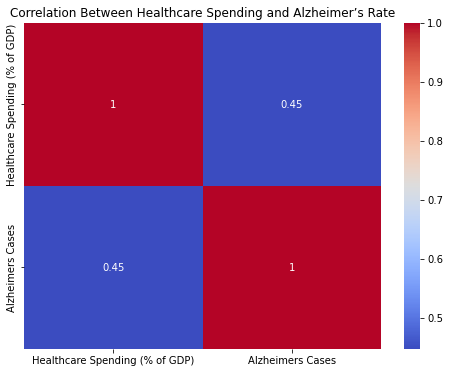

In [429]:
# Normalize Alzheimer’s prevalence to per 100k population
# data['Alzheimers Rate per 100k'] = (data['Alzheimers Cases'] / data['Population']) * 100000

#Filter for Rate values (i.e. normalized to 100000 population unit)
data = merged_data[(merged_data['metric_name']=='Rate')]

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Drop rows with missing values
data = data.dropna()

# Correlation analysis
print("\nCorrelation Matrix:")
print(data[['Healthcare Spending (% of GDP)', 'Alzheimers Cases']].corr())

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data[['Healthcare Spending (% of GDP)', 'Alzheimers Cases']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Healthcare Spending and Alzheimer’s Rate')
plt.show()

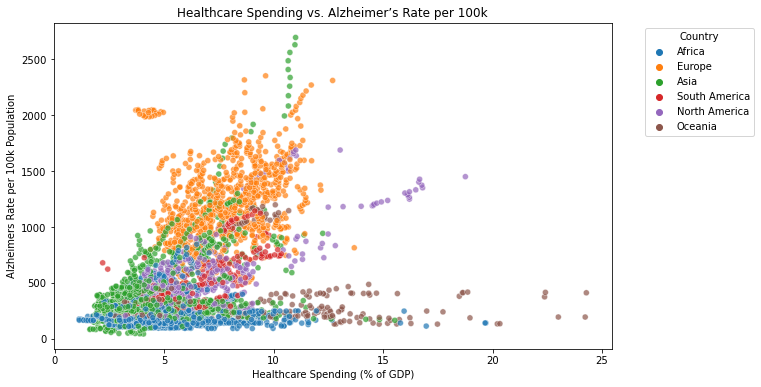

In [363]:
# Scatter plot: Healthcare Spending vs. Alzheimer’s Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Healthcare Spending (% of GDP)', y='Alzheimers Cases', hue='Continent', alpha=0.7)
# Split the legend into multiple columns for compactness
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', title='Continent', ncol=8)  # ncol sets the number of columns
plt.title('Healthcare Spending vs. Alzheimer’s Rate per 100k')
plt.xlabel('Healthcare Spending (% of GDP)')
plt.ylabel('Alzheimers Rate per 100k Population')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Country')
plt.show()

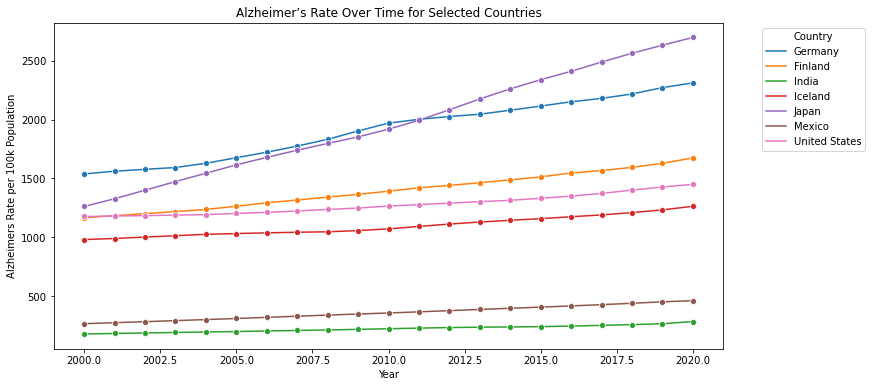

In [445]:
# Line plot: Alzheimer’s Rate Over Time for Selected Countries
countries = ['Japan', 'United States', 'India', 'Germany', 'Finland', 'Mexico', 'Iceland']  # Customize this list
filtered_data = data[data['Country'].isin(countries)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='Year', y='Alzheimers Cases', hue='Country', marker='o')
plt.title('Alzheimer’s Rate Over Time for Selected Countries')
plt.xlabel('Year')
plt.ylabel('Alzheimers Rate per 100k Population')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Country')
plt.show()

In [387]:
population_data['Year'].min()

1960.0

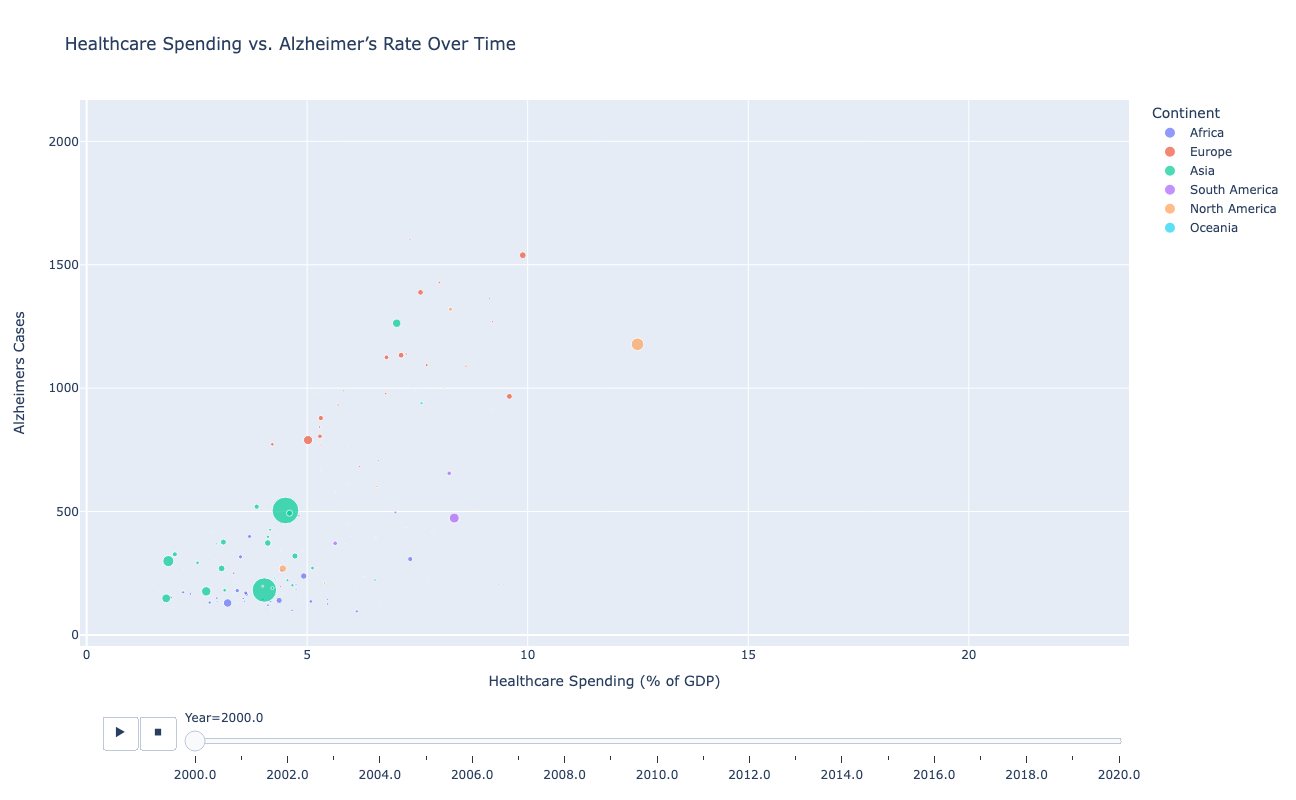

In [447]:
# Interactive Scatter Plot using Plotly
fig = px.scatter(data, x='Healthcare Spending (% of GDP)', y='Alzheimers Cases',
                 color='Continent', size='Population', hover_name='Country', 
                 animation_frame='Year', title='Healthcare Spending vs. Alzheimer’s Rate Over Time',
                 height=800)
fig.show()

# # Save cleaned dataset to a new CSV file
# data.to_csv('/mnt/data/cleaned_healthcare_alzheimers_data.csv', index=False)
# print("\nCleaned dataset saved as 'cleaned_healthcare_alzheimers_data.csv'.")

## Conclusion

This analysis highlights key insights into the relationship between healthcare spending and Alzheimer's disease prevalence. Interactive visualizations and further exploration are encouraged.